<a id="tableofcontents"></a>
# Table of Contents
- [Connect to synapse](#synapseconnect)
- [Subchallenge 1 data](#s1data)
- [Comparing Missing vs. Non-missing values](#missingornot)
- [Additional Analytics](#morecounts)

<a id="synapseconnect"></a>
## Connect to Synapse

In [10]:
import synapseclient
import synapseutils
import os
import configparser

config_path = os.path.join(os.environ['HOME'], '.synapseConfig')
cfg = configparser.ConfigParser()
cfg.read(config_path)
syn_usr = cfg.get("authentication", "username")
syn_pwd = cfg.get("authentication", "password")
syn = synapseclient.login(email=syn_usr, password=syn_pwd, rememberMe=True)

Welcome, Joy Rimchala!



<a id="s1data"></a>
# Subchallenge 1 data
Note we need to accept term of use on Synapse before the data can be downloaded.

back to [table of contents](#tableofcontents)

In [11]:
from synapseclient import Activity
from synapseclient import Entity, Project, Folder, File, Link
from synapseclient import Evaluation, Submission, SubmissionStatus
from synapseclient import Wiki
import numpy as np
import pandas as pd
from collections import OrderedDict
sub1_synapse_id = 'syn10139511'
if 'files' not in locals():
    files = synapseutils.syncFromSynapse(syn, sub1_synapse_id)

data_dict = OrderedDict()
for fl in files:
    data_dict[fl.name] = pd.read_csv(fl.path, sep='\t')

In [12]:
# For each Protein, what's the distribution of missing vs. non-missing values compared to truth
# Collect missing data stats across samples
missing = OrderedDict()
not_missing = OrderedDict()
ground_truth = data_dict['data_true.txt']
sample_cols = ground_truth.set_index('Gene_ID').columns
gene_list = ground_truth['Gene_ID'].value

for g in gene_list: 
    gtruth = ground_truth[ground_truth['Gene_ID']==g][sample_cols].values[0]
    for ds, obs in [(k, v) for (k, v) in data_dict.items() if not k.endswith('_true.txt')]:
        gobs = obs[obs['Gene_ID']==g][sample_cols].values[0]
        missing[ds, g] = gtruth[pd.isnull(gobs)]
        not_missing[ds, g] = gtruth[pd.notnull(gobs)]

        if g.endswith("500") & ds.endswith("9.txt"): 
            print("obs {}: gene: {}".format(ds, g))

obs data_obs_9.txt: gene: Protein_500
obs data_obs_9.txt: gene: Protein_1500
obs data_obs_9.txt: gene: Protein_2500
obs data_obs_9.txt: gene: Protein_3500
obs data_obs_9.txt: gene: Protein_4500
obs data_obs_9.txt: gene: Protein_5500
obs data_obs_9.txt: gene: Protein_6500
obs data_obs_9.txt: gene: Protein_7500


<a id="missingornot"></a>
## Comparing missing vs. non-missing values distributions
- [Aggregating values across samples by proteins](#byprotein)
- [Aggregating values across proteins by samples](#bysample)

back to [table of contents](#tableofcontents)

In [171]:
# Utility functions
def _dim_dict():
    return {'sample':0, 'protein':1}    
    
def missing_categories_slice(missing, not_missing, _id, dim):
    # keys in missing dict is a tuple (sample_id, protein_id)
    all_samples_missing = []
    all_samples_not_missing = []
    for a in filter(lambda x: x[_dim_dict()[dim]] == _id, missing.keys()): 
        all_samples_missing.extend(missing[a])
        all_samples_not_missing.extend(not_missing[a])

    return all_samples_missing, all_samples_not_missing


def plot_histogram_missing_slice(all_samples_missing, all_samples_not_missing, _id, bin_missing=50, bin_not_missing=50):
    % pylab inline
    import seaborn as sns
    sns.set_style('white')
    sns.set_palette("hls", 4)

    fig, ax = plt.subplots(figsize=(5,4))
    alpha = 0.70
    ftsize = 20
    ax.hist(all_samples_not_missing, alpha=alpha, bins=bin_not_missing)
    ax.hist(all_samples_missing, alpha=alpha, bins=bin_missing)
    ax.grid('on')
    ax.set_title(_id, fontsize=ftsize)
    ax.set_xlabel('Protein level', fontsize=round(0.8*ftsize))
    ax.set_ylabel('number of samples', fontsize=round(0.8*ftsize))
    ax.legend(['not_missing', 'missing'], fontsize=round(0.7*ftsize))
    plt.show()

<a id="byprotein"></a>
### Aggregating values across samples by proteins

Populating the interactive namespace from numpy and matplotlib


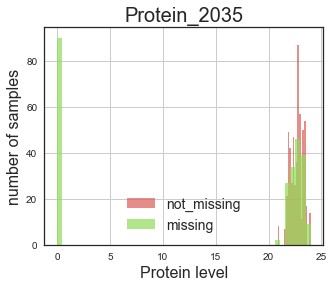

Populating the interactive namespace from numpy and matplotlib


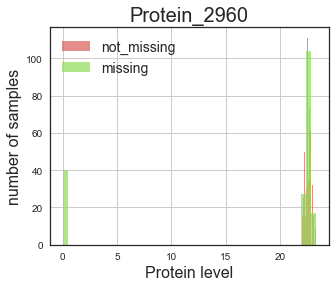

Populating the interactive namespace from numpy and matplotlib


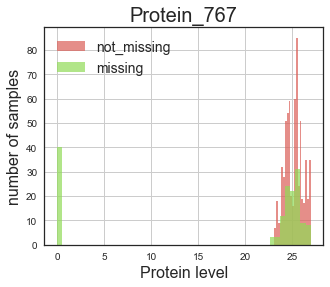

Populating the interactive namespace from numpy and matplotlib


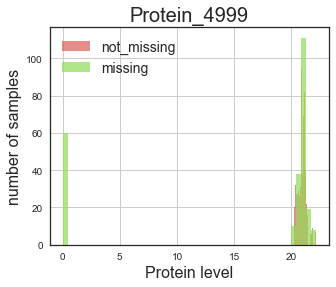

Populating the interactive namespace from numpy and matplotlib


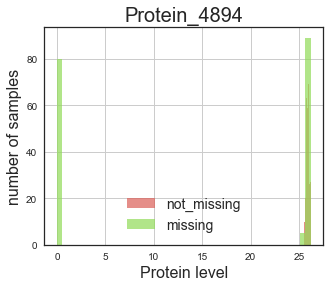

In [172]:
protein_ids = unique(list(map(lambda x: x[_dim_dict()['protein']], missing.keys())))
num_samples = 5
random_proteins = protein_ids[np.random.randint(low=0, high=len(protein_ids), size=num_samples)]

for _id in random_proteins:
    all_samples_missing, all_samples_not_missing = missing_categories_slice(missing, not_missing, _id=_id, dim='protein')
    plot_histogram_missing_slice(all_samples_missing, all_samples_not_missing, _id, bin_missing=50, bin_not_missing=20)
    plt.show()

<a id="bysample"></a>
### Aggregating values across proteins by samples

Populating the interactive namespace from numpy and matplotlib


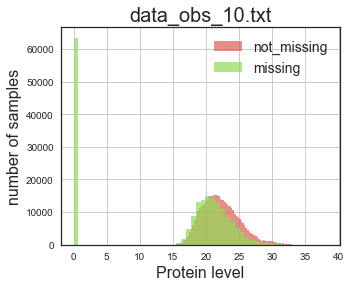

Populating the interactive namespace from numpy and matplotlib


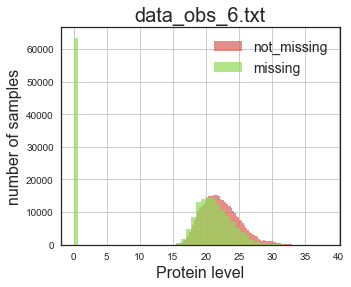

Populating the interactive namespace from numpy and matplotlib


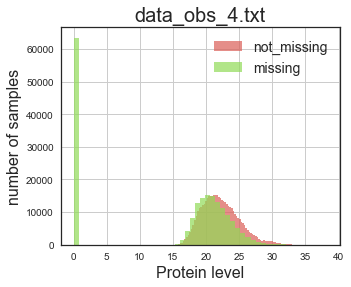

Populating the interactive namespace from numpy and matplotlib


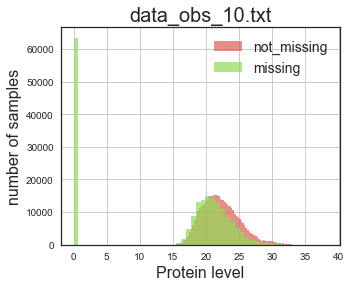

Populating the interactive namespace from numpy and matplotlib


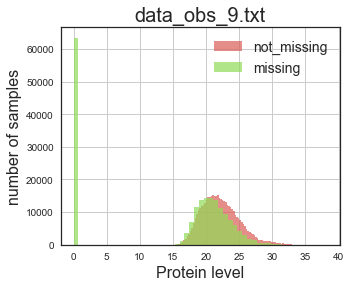

In [175]:
dim='sample'
_ids = unique(list(map(lambda x: x[_dim_dict()[dim]], missing.keys())))
num_samples = 5
randoms = _ids[np.random.randint(low=0, high=len(_ids), size=num_samples)]

for _id in randoms:
    all_samples_missing, all_samples_not_missing = missing_categories_slice(missing, not_missing, _id=_id, dim=dim)
    plot_histogram_missing_slice(all_samples_missing, all_samples_not_missing, _id, bin_missing=50, bin_not_missing=100)
    plt.show()

<a id="morecounts"></a>
## Additional Analytics
- Total number of missing values
- Total number of observations
- Missing value ratio
- Number of missing proteins per samples
- Proportions of zeros (NMAR) vs non-zeros (MAR) per samples

back to [table of contents](#tableofcontents)

In [256]:
sample_cols = list(filter(lambda x: x.startswith('Sample'), data_dict['data_true.txt'].columns))
thres = 1
num_samples = 80
missing_counts_by_sample_by_protein = [
    (
        k[0], # observation id
        k[1], # protein id
        len(missing[k]), # total missing
        len([v for v in missing[k] if v >= thres]), # MAR
        len([v for v in missing[k] if v < thres])  # NMAR
    )
    for k in missing.keys()
]
missing_category = pd.DataFrame(missing_counts_by_sample_by_protein)
missing_category.columns = ['obs_id', 'Gene_ID', 'total_missing', 'MAR', 'NMAR']
missing_category['fraction_missing_total'] = missing_category['total_missing'].astype(float)/num_samples
missing_category['fraction_NMAR'] = missing_category['NMAR'].astype(float)/missing_category['total_missing']

not_missing_counts_by_sample_by_protein = [
    (
        k[0], # observation id
        k[1], # protein id
        len(not_missing[k]) # total not missing
    )
    for k in not_missing.keys()
]
not_missing_category = pd.DataFrame(not_missing_counts_by_sample_by_protein)
not_missing_category.columns = ['obs_id', 'Gene_ID', 'total_not_missing']
missing_category.to_csv('../data/missing_stats.csv', index=False)
not_missing_category.to_csv('../data/not_missing_stats.csv', index=False)

In [304]:
total_number_of_missing_values = missing_category['total_missing'].sum()
num_samples = 80
total_observations = len(missing_category)*num_samples
print("Total Missing Values : {}".format(total_number_of_missing_values))
print("Total Number of Observations : {}".format(len(missing_category)*num_samples))
print("Global Percentage of Missing Values: %.2f " % (float(total_number_of_missing_values)/total_observations*100))

Total Missing Values : 1904745
Total Number of Observations : 6341600
Global Percentage of Missing Values: 30.04 


## Distribution of fraction Missing Values and NMARs by Sample by GeneID

Average number of missing values : 24.029
Standard deviation of number of missing values : 5.809
95% CI number of total missing: (12.642296867003559, 12.642296867003559)
Average percent of missing values : 30.036
Standard deviation of percent missing values : 7.262
95% CI percent of total missing: (15.80287108375445, 44.268561993071586)


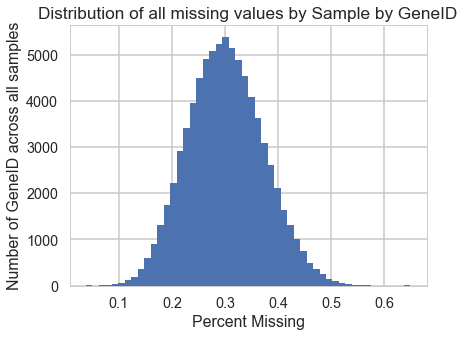

In [341]:
ax = missing_category['fraction_missing_total'].hist(bins=50, figsize=(6.4, 4.8))
ax.set_xlabel("Percent Missing")
ax.set_ylabel("Number of GeneID across all samples")
ax.set_title("Distribution of all missing values by Sample by GeneID")

mean_total_missing = missing_category['total_missing'].mean()
std_total_missing = missing_category['total_missing'].std()
CI95_total_missing = (
    mean_total_missing-1.96*std_total_missing, 
    mean_total_missing-1.96*std_total_missing
)

mean_percent_missing = missing_category['fraction_missing_total'].mean()*100
std_percent_missing = missing_category['fraction_missing_total'].std()*100
CI95_percent_missing = (
    mean_percent_missing-1.96*std_percent_missing, 
    mean_percent_missing+1.96*std_percent_missing
)

print("Average number of missing values : %.3f" % mean_total_missing)
print("Standard deviation of number of missing values : %.3f" % std_total_missing)
print("95% CI number of total missing:", CI95_total_missing)
print("Average percent of missing values : %.3f" % mean_percent_missing)
print("Standard deviation of percent missing values : %.3f" % std_percent_missing)
print("95% CI percent of total missing:", CI95_percent_missing)

Average number of NMAR : 8.000
Standard deviation of NMAR of : 2.703
95% CI number of NMAR: (2.7020096868090819, 2.7020096868090819)
Average percent of percent NMAR (out of total missing): 34.373
Standard deviation of percent NMAR (out of total missing) : 12.037
95% CI percent of percent NMAR (out of total missing): (10.781362613869767, 57.96471288457645)


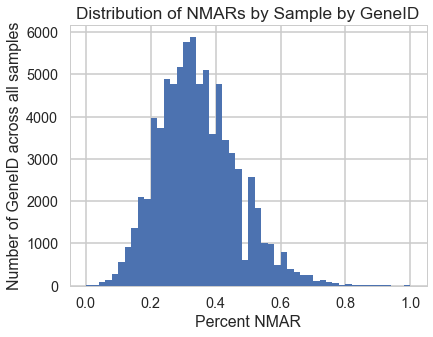

In [343]:
ax = missing_category['fraction_NMAR'].hist(bins=50, figsize=(6.4, 4.8))
ax.set_xlabel("Percent NMAR")
ax.set_ylabel("Number of GeneID across all samples")
ax.set_title("Distribution of NMARs by Sample by GeneID")

mean_number_NMAR = missing_category['NMAR'].mean()
std_number_NMAR = missing_category['NMAR'].std()
CI95_total_NMAR = (
    mean_number_NMAR-1.96*std_number_NMAR, 
    mean_number_NMAR-1.96*std_number_NMAR
)

mean_percent_NMAR = missing_category['fraction_NMAR'].mean()*100
std_percent_NMAR = missing_category['fraction_NMAR'].std()*100
CI95_percent_NMAR = (
    mean_percent_NMAR-1.96*std_percent_NMAR, 
    mean_percent_NMAR+1.96*std_percent_NMAR
)

print("Average number of NMAR : %.3f" % mean_number_NMAR)
print("Standard deviation of NMAR of : %.3f" % std_number_NMAR)
print("95% CI number of NMAR:", CI95_total_NMAR)
print("Average percent of percent NMAR (out of total missing): %.3f" % mean_percent_NMAR)
print("Standard deviation of percent NMAR (out of total missing) : %.3f" % std_percent_NMAR)
print("95% CI percent of percent NMAR (out of total missing):", CI95_percent_NMAR)


### Observations
- Unskewed Unimodal distribution of all missing values across all gene and samples.
- Average number of missing values across all genes and all samples ~ 30.04 +/-7.26 %

- Approximately Unimodel distribution of NMAR across all genes and samples 
- Out of total missing values, the average NMARs across all genes and all samples ~ 34.37+/-12.04%

## Distribution of Missing Values vs. NMARs by Sample by GeneID

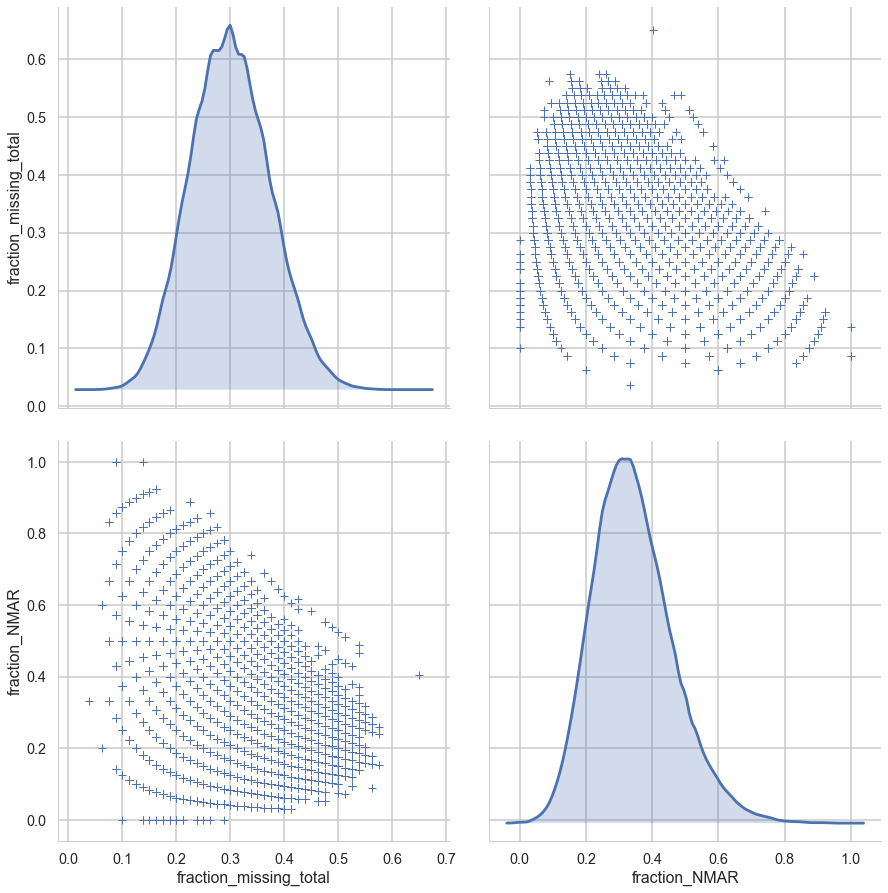

In [274]:
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("poster", font_scale=0.9) 
splot = sns.pairplot(missing_category[['fraction_missing_total', 'fraction_NMAR']], 
                     size=6.4, markers="+", diag_kind='kde',palette="husl",
                     plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                     diag_kws=dict(shade=True)
                    )


In [261]:
# Exploring the data
# 1. Visualize the distribution of data in each dimension. Is it mostly Gaussian?
# 2. Is the missing data draw from the same distribution as the original data?
# 3. PCA
# Y.shape

(80, 7927)
Populating the interactive namespace from numpy and matplotlib


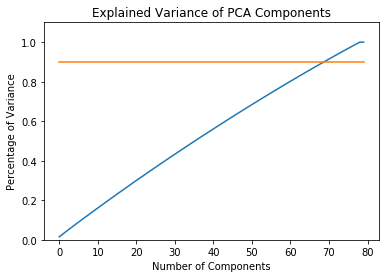

In [40]:
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 80 samples, 7927 proteins
ground_truth = data_dict['data_true.txt']
Y = ground_truth.set_index('Gene_ID').T.as_matrix()
# Yscaled = MinMaxScaler().fit_transform(Y)
Yscaled = StandardScaler().fit_transform(Y)
print(Yscaled.shape)

pca = sklearnPCA()
nc = 80
pca = sklearnPCA(n_components=nc, whiten=True)
Ypca = pca.fit_transform(Yscaled)
evr = np.cumsum(pca.explained_variance_ratio_)

%pylab inline
plt.plot(evr)
plt.plot([0.9]*nc)
plt.ylim((0.0, 1.1))
plt.title('Explained Variance of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Variance')

# KMeans
# kmscores = [KMeans(i, n_init=25).fit(Y).score(Y) for i in range(1, 50)]
# kmscores = list()
# for i in range(1,50):
#     km = KMeans(i,n_init=25)
#     km.fit(Y)
#     kmscores.append(km.score(Y))

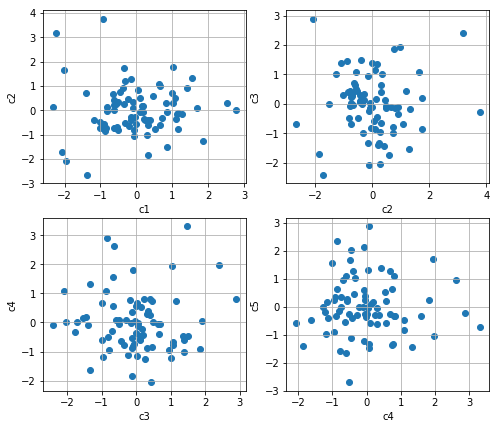

In [58]:
# Plot component by component
fig, ax = plt.subplots(2,2, figsize=(8,7))
ax[0, 0].scatter(Ypca[:, 0], Ypca[:, 1])
ax[0, 0].grid('on')
ax[0, 0].set_xlabel('c1')
ax[0, 0].set_ylabel('c2')

ax[0, 1].scatter(Ypca[:, 1], Ypca[:, 2])
ax[0, 1].grid('on')
ax[0, 1].set_xlabel('c2')
ax[0, 1].set_ylabel('c3')

ax[1, 0].scatter(Ypca[:, 2], Ypca[:, 3])
ax[1, 0].grid('on')
ax[1, 0].set_xlabel('c3')
ax[1, 0].set_ylabel('c4')

ax[1, 1].scatter(Ypca[:, 3], Ypca[:, 4])
ax[1, 1].grid('on')
ax[1, 1].set_xlabel('c4')
ax[1, 1].set_ylabel('c5')

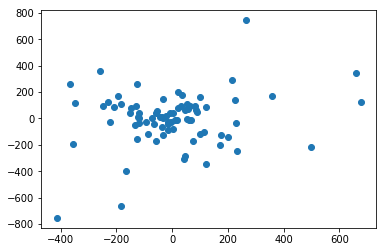

In [41]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=10, random_state=0)
np.set_printoptions(suppress=True)
Ytsne = tsne.fit_transform(Yscaled) 

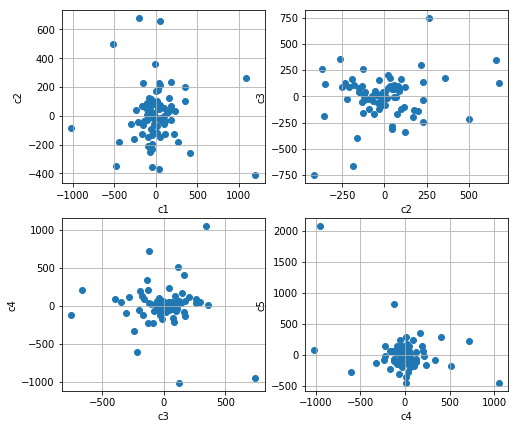

In [57]:
# Plot component by component
fig, ax = plt.subplots(2,2, figsize=(8,7))
ax[0, 0].scatter(Ytsne[:, 0], Ytsne[:, 1])
ax[0, 0].grid('on')
ax[0, 0].set_xlabel('c1')
ax[0, 0].set_ylabel('c2')

ax[0, 1].scatter(Ytsne[:, 1], Ytsne[:, 2])
ax[0, 1].grid('on')
ax[0, 1].set_xlabel('c2')
ax[0, 1].set_ylabel('c3')

ax[1, 0].scatter(Ytsne[:, 2], Ytsne[:, 3])
ax[1, 0].grid('on')
ax[1, 0].set_xlabel('c3')
ax[1, 0].set_ylabel('c4')

ax[1, 1].scatter(Ytsne[:, 3], Ytsne[:, 4])
ax[1, 1].grid('on')
ax[1, 1].set_xlabel('c4')
ax[1, 1].set_ylabel('c5')

In [107]:
# Reshape ground_truth data into the following format: 
# sample gene_ID expression timestamp
import datetime
d = datetime.datetime.utcnow()
long_ground_truth = pd.melt(ground_truth, id_vars=['Gene_ID'], value_vars=sample_cols.tolist())
long_ground_truth = long_ground_truth.rename(columns={'variable': 'Sample_ID'})
long_ground_truth['rand_add'] = np.random.randint(low=0, high=100000, size=(len(long_ground_truth), 1))
long_ground_truth['timestamp'] = long_ground_truth['rand_add'] + (datetime.datetime.utcnow() - datetime.datetime(1970,1,1)).total_seconds()
long_ground_truth[['Sample_ID', 'Gene_ID', 'value', 'timestamp']].to_csv('../data/data_true_long.tsv', sep='\t', header=None, index=False)

In [111]:
from surprise import SVD
from surprise import Dataset
from surprise.dataset import Reader
from surprise import evaluate, print_perf
reader = Reader(line_format='user item rating timestamp', sep='\t')
data = Dataset.load_from_file('../data/data_true_long.tsv', reader=reader)
data.split(n_folds=5)
algo = SVD()

# Evaluate performances of our algorithm on the dataset.
perf = evaluate(algo, data, measures=['RMSE', 'MAE'])

print_perf(perf)

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 16.4289
MAE:  15.8000
------------
Fold 2
RMSE: 16.4423
MAE:  15.8137
------------
Fold 3
RMSE: 16.4474
MAE:  15.8211
------------
Fold 4
RMSE: 16.4223
MAE:  15.7897
------------
Fold 5
RMSE: 16.4156
MAE:  15.7903
------------
------------
Mean RMSE: 16.4313
Mean MAE : 15.8030
------------
------------
        Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    
MAE     15.8000 15.8137 15.8211 15.7897 15.7903 15.8030 
RMSE    16.4289 16.4423 16.4474 16.4223 16.4156 16.4313 
